<a href="https://colab.research.google.com/github/danplotkin/ProtienPrediction/blob/main/ProtienPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get Data via Kaggle API

## Save secrets to `os.environ`

In [1]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

## Download Dataset from Competition

In [2]:
!kaggle competitions download -c "cafa-5-protein-function-prediction"
!mkdir "cafa-5-protein-function-prediction"
!unzip "cafa-5-protein-function-prediction.zip" -d "cafa-5-protein-function-prediction/"

 98% 113M/115M [00:03<00:00, 43.8MB/s]
100% 115M/115M [00:03<00:00, 35.5MB/s]
Archive:  cafa-5-protein-function-prediction.zip
  inflating: cafa-5-protein-function-prediction/IA.txt  
  inflating: cafa-5-protein-function-prediction/Test (Targets)/testsuperset-taxon-list.tsv  
  inflating: cafa-5-protein-function-prediction/Test (Targets)/testsuperset.fasta  
  inflating: cafa-5-protein-function-prediction/Train/go-basic.obo  
  inflating: cafa-5-protein-function-prediction/Train/train_sequences.fasta  
  inflating: cafa-5-protein-function-prediction/Train/train_taxonomy.tsv  
  inflating: cafa-5-protein-function-prediction/Train/train_terms.tsv  
  inflating: cafa-5-protein-function-prediction/sample_submission.tsv  


## Download T5 Protien Embeddings

In [3]:
!kaggle datasets download -d "sergeifironov/t5embeds"
!mkdir "t5embeds"
!unzip "/content/t5embeds.zip" -d "t5embeds/"

100% 1.22G/1.22G [00:31<00:00, 41.7MB/s]
100% 1.22G/1.22G [00:31<00:00, 41.1MB/s]
Archive:  /content/t5embeds.zip
  inflating: t5embeds/test_embeds.npy  
  inflating: t5embeds/test_ids.npy   
  inflating: t5embeds/train_embeds.npy  
  inflating: t5embeds/train_ids.npy  


# Import Libraries

In [4]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 5)

from sklearn.model_selection import train_test_split
import tensorflow as tf

from typing import Union

# Define Configs

In [5]:
BATCH_SIZE = 512
LR = 1e-3
EPOCHS = 20

# Import Data

## Import Train Terms

In [6]:
train_terms = pd.read_csv(
    "cafa-5-protein-function-prediction/Train/train_terms.tsv",
    sep='\t'
)
train_terms

,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO
2,A0A009IHW8,GO:0072523,BPO
3,A0A009IHW8,GO:0044270,BPO
4,A0A009IHW8,GO:0006753,BPO
...,...,...,...
5363858,X5L565,GO:0050649,MFO
5363859,X5L565,GO:0016491,MFO
5363860,X5M5N0,GO:0005515,MFO
5363861,X5M5N0,GO:0005488,MFO


In [7]:
train_terms['term'].nunique()

31466

In [8]:
filtered_terms = train_terms['term'].value_counts()[:5000].index.tolist()
train_terms_filtered = train_terms[train_terms['term'].isin(filtered_terms)]
train_terms_filtered

,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO
2,A0A009IHW8,GO:0072523,BPO
3,A0A009IHW8,GO:0044270,BPO
4,A0A009IHW8,GO:0006753,BPO
...,...,...,...
5363857,X5L565,GO:0003674,MFO
5363859,X5L565,GO:0016491,MFO
5363860,X5M5N0,GO:0005515,MFO
5363861,X5M5N0,GO:0005488,MFO


In [9]:
# Get unqiue labels
labels = train_terms_filtered['term'].unique().tolist()

# Get length of labels
n_labels = len(labels)
print(n_labels)

5000


## Import Embeddings

In [10]:
# Load in the embeddings
train_embeddings = np.load("t5embeds/train_embeds.npy")
print(f"Embedings shape: {train_embeddings.shape}")

# Load in the ids for the embeddings
train_input_ids = np.load("t5embeds/train_ids.npy")
print(f"Ids shape: {train_input_ids.shape}")

Embedings shape: (142246, 1024)
Ids shape: (142246,)


# Plot Aspect Distribution

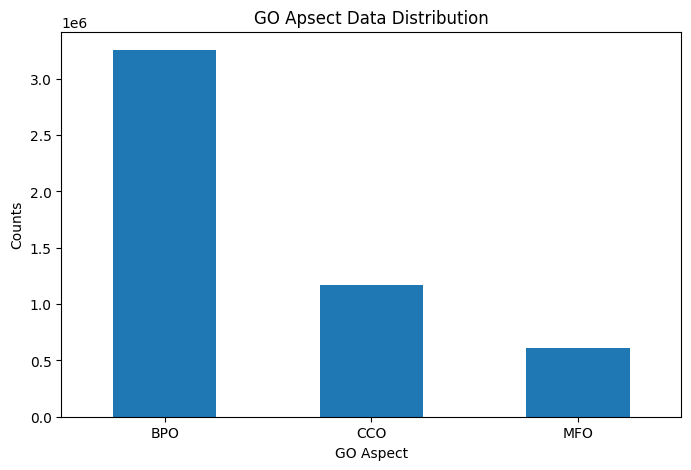

In [11]:
train_terms_filtered['aspect'].value_counts().plot(kind='bar')
plt.xlabel('GO Aspect')
plt.ylabel('Counts')
plt.title('GO Apsect Data Distribution')
plt.xticks(rotation=0)
plt.show()

# Plot Top 25 Terms in Dataset

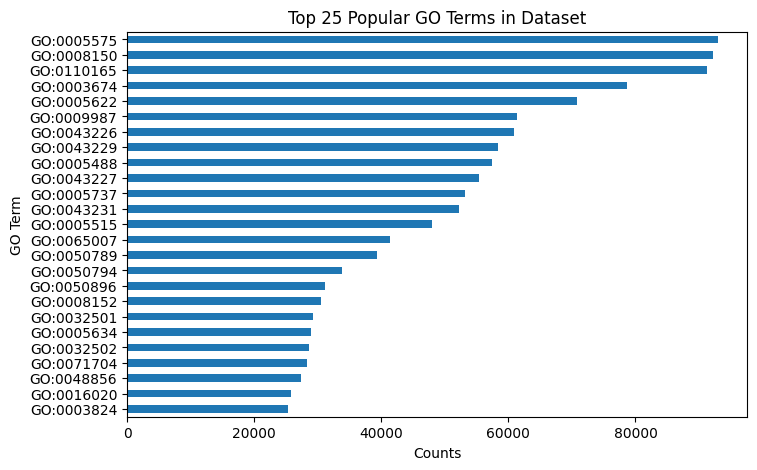

In [12]:
train_terms_filtered['term'].value_counts()[:25].sort_values(ascending=True).plot(kind='barh')
plt.xticks(rotation=0)
plt.xlabel('Counts')
plt.ylabel('GO Term')
plt.title('Top 25 Popular GO Terms in Dataset')
plt.show()

# Preprocess Data

## Create Train DataFrame

In [13]:
def make_features(embeddings: np.ndarray,
                  input_ids: np.ndarray,
                  ids_filter: Union[list[str], None] = None) -> pd.DataFrame:
    """
    Maps input ids to embeddings as a Pandas DataFrame.
    """
    df = pd.DataFrame(
        data=embeddings,
        index=input_ids,
        columns=[f"dim_{i}" for i in range(embeddings.shape[-1])]
    )
    if ids_filter is not None:
        return df.loc[ids_filter]
    return df

In [14]:
train_df = make_features(
    embeddings=train_embeddings,
    input_ids=train_input_ids,
    ids_filter=train_terms_filtered['EntryID'].unique().tolist()
)

train_df

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,...,dim_1014,dim_1015,dim_1016,dim_1017,dim_1018,dim_1019,dim_1020,dim_1021,dim_1022,dim_1023
A0A009IHW8,0.067778,-0.046573,0.001871,-0.008532,0.003735,0.046137,-0.059283,-0.049906,-0.005312,0.008608,...,-0.040293,-0.013106,-0.049407,-0.100177,0.066018,0.009035,-0.003596,-0.024547,0.034698,-0.030786
A0A021WW32,-0.016303,-0.001599,0.003910,0.073261,0.012426,0.028077,-0.040412,-0.093539,-0.017918,0.025457,...,0.011927,-0.033233,-0.031254,-0.005067,0.014727,0.081792,0.017501,-0.033023,0.053113,0.029803
A0A023FFD0,0.021001,0.042716,0.129339,-0.020049,-0.052877,-0.022260,-0.032948,-0.133599,0.018082,-0.004892,...,-0.064550,-0.060862,0.019891,-0.101481,0.090662,-0.086926,-0.035450,-0.008333,0.112551,0.056747
A0A023GPJ3,0.015160,0.010921,0.021771,-0.025145,0.039606,0.008339,-0.051439,-0.025277,-0.020316,-0.009789,...,-0.027280,-0.029346,-0.051212,-0.062370,0.023346,0.065942,0.024990,-0.040491,0.026009,0.018068
A0A023GPK8,-0.006443,0.010684,-0.005747,0.027586,0.030306,0.023630,-0.018534,-0.036524,0.031592,0.025155,...,0.020279,0.021153,-0.000990,-0.069552,0.036506,0.028183,-0.004196,-0.016354,0.045007,0.017675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X5CY81,0.008123,0.043224,0.024250,0.051577,-0.023608,0.000123,-0.049327,-0.101638,0.017005,0.001511,...,0.003208,-0.033734,0.006680,-0.069324,0.028294,-0.032713,-0.036853,-0.002590,0.003340,0.016889
X5D6G5,-0.014871,-0.035978,0.008368,0.010812,-0.023133,0.001024,-0.042632,0.047851,0.018510,0.000870,...,0.002811,0.048873,0.081695,-0.092719,0.006731,0.094610,-0.025961,0.012268,-0.074793,-0.074373
X5D778,0.025453,0.029417,0.016788,0.022848,0.008182,0.030478,-0.036648,-0.059158,-0.010503,-0.002075,...,-0.040438,-0.036937,-0.003581,-0.002983,0.016977,0.042060,-0.013662,0.005797,-0.025595,0.001287
X5E0F1,0.004228,-0.016491,0.003560,0.002463,-0.010172,0.014856,-0.055861,-0.031247,-0.032213,-0.058266,...,-0.012949,-0.009479,-0.006582,-0.069031,0.060998,0.010650,0.006252,-0.009251,0.051015,0.035989


## Create Train Labels

In [15]:
%%time
# Initialize array
labels_array = np.zeros((train_df.shape[0], n_labels))

# Initialize DataFrame
labels_df = pd.DataFrame(
    data=labels_array,
    columns=labels,
    index=train_df.index
)

# Get all mapped terms from the train_terms DataFrame
mapped_terms = train_terms_filtered.groupby('EntryID')['term'].apply(set).to_dict()

# Iterate over each protein ID and column name
for protein_id, row in tqdm(labels_df.iterrows(), total=len(labels_df)):
    # Get the set of mapped terms for the protein ID
    mapped_terms_set = mapped_terms[protein_id]
    # Update the corresponding entries in the DataFrame to 1.0 where the mapped terms match the column names
    labels_df.loc[protein_id, list(mapped_terms_set.intersection(labels_df.columns))] = 1.0

labels_df.head()

  0%|          | 0/142246 [00:00<?, ?it/s]

CPU times: user 4min 27s, sys: 5.35 s, total: 4min 33s
Wall time: 4min 31s


,GO:0008152,GO:0034655,GO:0072523,GO:0044270,GO:0006753,GO:1901292,GO:0044237,GO:1901360,GO:0008150,GO:1901564,...,GO:0000217,GO:0019843,GO:0008376,GO:0008175,GO:0008187,GO:0045309,GO:0016409,GO:0015295,GO:0043495,GO:0001786
A0A009IHW8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0A021WW32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0A023FFD0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0A023GPJ3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0A023GPK8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
train_df.shape, labels_df.shape

((142246, 1024), (142246, 5000))

In [17]:
np.array_equal(train_df.index.values, labels_df.index.values)

True

## Create Validation Set

In [18]:
X_train, X_val, y_train, y_val = train_test_split(
    train_df.values.astype(np.float32),
    labels_df.values.astype(np.float32),
    test_size=0.2,
    random_state=42
)

# Create Network

In [19]:
# Define using sequential
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(train_df.shape[1],)),
    tf.keras.layers.Dense(1024),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(512),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dense(labels_df.shape[1], activation='sigmoid'),
])

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()]
)

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

# Train Network

In [20]:
%%time
# Train the model
history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val)
)

Epoch 1/20
223/223 [==============================] - 12s 27ms/step - loss: 0.0536 - binary_accuracy: 0.9886 - auc: 0.8416 - val_loss: 0.0287 - val_binary_accuracy: 0.9932 - val_auc: 0.8790
Epoch 2/20
223/223 [==============================] - 5s 21ms/step - loss: 0.0254 - binary_accuracy: 0.9934 - auc: 0.9171 - val_loss: 0.0257 - val_binary_accuracy: 0.9934 - val_auc: 0.9222
Epoch 3/20
223/223 [==============================] - 5s 21ms/step - loss: 0.0240 - binary_accuracy: 0.9935 - auc: 0.9286 - val_loss: 0.0238 - val_binary_accuracy: 0.9935 - val_auc: 0.9292
Epoch 4/20
223/223 [==============================] - 5s 21ms/step - loss: 0.0232 - binary_accuracy: 0.9936 - auc: 0.9361 - val_loss: 0.0231 - val_binary_accuracy: 0.9936 - val_auc: 0.9376
Epoch 5/20
223/223 [==============================] - 5s 21ms/step - loss: 0.0226 - binary_accuracy: 0.9936 - auc: 0.9412 - val_loss: 0.0227 - val_binary_accuracy: 0.9936 - val_auc: 0.9349
Epoch 6/20
223/223 [==============================] - 

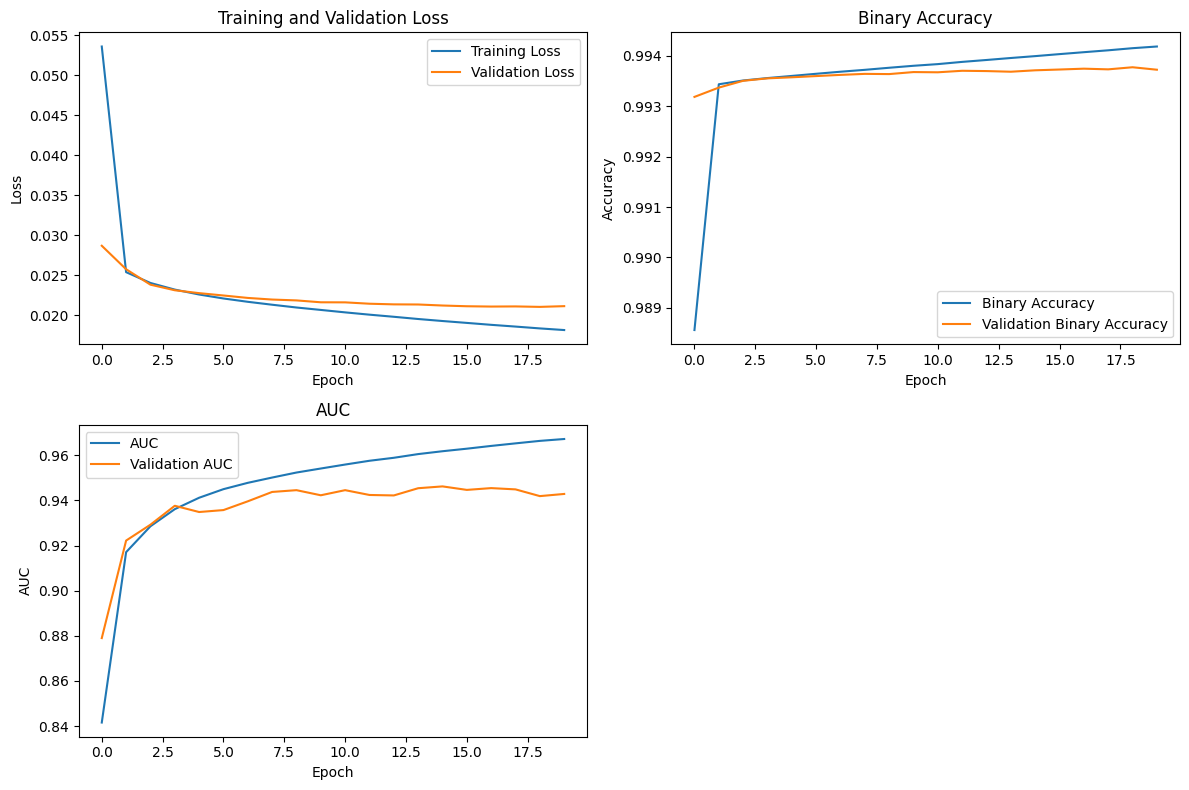

In [21]:
# Plot training history for each metric/loss
plt.figure(figsize=(12, 8))

# Plot Training and Validation Loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Binary Accuracy
plt.subplot(2, 2, 2)
plt.plot(history.history['binary_accuracy'], label='Binary Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Binary Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Binary Accuracy')
plt.legend()

# Plot AUC
plt.subplot(2, 2, 3)
plt.plot(history.history['auc'], label='AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('AUC')
plt.legend()

plt.tight_layout()
plt.show()

# Create Submission

## Prepare Inputs

In [22]:
test_data = make_features(
    embeddings=np.load('/content/t5embeds/test_embeds.npy'),
    input_ids=np.load('/content/t5embeds/test_ids.npy')
)

test_data

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,...,dim_1014,dim_1015,dim_1016,dim_1017,dim_1018,dim_1019,dim_1020,dim_1021,dim_1022,dim_1023
Q9CQV8,0.054705,0.063420,-0.015320,-0.016506,0.042195,0.021592,-0.118535,-0.063298,-0.046146,-0.102311,...,-0.019581,-0.043712,-0.072322,0.002404,0.018459,-0.047278,0.012195,-0.043319,0.036009,0.063093
P62259,0.090373,0.089842,-0.023887,-0.011446,0.051465,0.020982,-0.110989,-0.066646,-0.041259,-0.087551,...,-0.024399,-0.041957,-0.066329,0.006856,0.028449,-0.053758,0.009699,-0.053350,0.019644,0.079630
P68510,0.043588,0.039572,-0.014332,-0.011769,0.045109,0.015847,-0.103339,-0.047735,-0.022730,-0.091452,...,-0.029648,-0.037944,-0.046043,0.003603,0.018028,-0.030746,0.003671,-0.044464,0.030974,0.040322
P61982,0.055668,0.049560,-0.019646,-0.006977,0.039897,0.021177,-0.108079,-0.047191,-0.031517,-0.100057,...,-0.023210,-0.041704,-0.048440,0.006088,0.020110,-0.046751,-0.006635,-0.041455,0.016683,0.057030
O70456,0.022637,0.014306,-0.002696,-0.034456,0.034854,0.020822,-0.114046,-0.050019,-0.026491,-0.097928,...,-0.019185,-0.032108,-0.051394,0.008448,0.015208,-0.037987,0.030977,-0.042407,0.041232,0.047161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P08380,0.081780,0.077098,0.006294,-0.073283,-0.064078,0.011976,0.018399,-0.102211,0.078021,0.018553,...,-0.030738,-0.039566,-0.096722,-0.127187,0.076231,0.012758,0.037633,0.005712,0.054623,0.024194
C0HK72,0.041950,0.159886,0.033731,-0.087298,-0.002340,-0.015892,0.034585,-0.163370,-0.030956,-0.047006,...,-0.073472,-0.017192,-0.026210,-0.072754,-0.017928,-0.027033,0.030544,0.016664,0.058192,-0.004196
C0HK73,0.032748,0.141868,0.034142,-0.063111,-0.006216,-0.025474,0.036954,-0.156333,-0.021958,-0.040103,...,-0.067549,-0.024079,-0.042062,-0.069278,-0.028636,-0.009337,0.035751,0.020646,0.054677,-0.015048
C0HK74,0.052713,0.157013,0.043279,-0.065428,-0.010776,-0.034223,0.042106,-0.156888,-0.020948,-0.047612,...,-0.061063,-0.011962,-0.006918,-0.067281,0.026953,-0.025858,0.041463,0.021591,0.062583,-0.014903


## Make Prediction

In [23]:
preds = model.predict(test_data)

4434/4434 [==============================] - 7s 2ms/step


In [24]:
preds_df = pd.DataFrame(preds, index=test_data.index, columns=labels)
preds_df.index.name = 'ProtienID'
preds_df.head()

,GO:0008152,GO:0034655,GO:0072523,GO:0044270,GO:0006753,GO:1901292,GO:0044237,GO:1901360,GO:0008150,GO:1901564,...,GO:0000217,GO:0019843,GO:0008376,GO:0008175,GO:0008187,GO:0045309,GO:0016409,GO:0015295,GO:0043495,GO:0001786
ProtienID,,,,,,,,,,,,,,,,,,,,,
Q9CQV8,0.060708,0.000639,0.000026,0.000566,0.001422,0.000041,0.045378,0.014512,0.776377,0.033379,...,0.000559,0.000060,0.000006,0.000003,0.000465,0.029000,0.000013,0.000005,0.000695,0.000169
P62259,0.093590,0.000431,0.000034,0.000292,0.003288,0.000063,0.075945,0.022508,0.715555,0.049663,...,0.000560,0.000141,0.000019,0.000009,0.000784,0.048372,0.000052,0.000014,0.003058,0.000334
P68510,0.077014,0.001073,0.000140,0.000885,0.002683,0.000100,0.063308,0.024131,0.788219,0.059381,...,0.000696,0.000076,0.000012,0.000008,0.000894,0.038678,0.000044,0.000028,0.001619,0.000291
P61982,0.063737,0.000535,0.000079,0.000399,0.002125,0.000069,0.059808,0.021351,0.810913,0.035499,...,0.000676,0.000064,0.000009,0.000007,0.000745,0.044798,0.000030,0.000027,0.001129,0.000329
O70456,0.047157,0.000411,0.000062,0.000436,0.001292,0.000055,0.033497,0.010806,0.787118,0.034252,...,0.000302,0.000028,0.000004,0.000005,0.000268,0.021399,0.000015,0.000017,0.000582,0.000111


## Save Predictions Locally

In [25]:
os.makedirs('outputs', exist_ok=True)
preds_df.to_parquet('outputs/preds_unmelted.parquet', index=True)

### Clear Session Memory to Optimize RAM

In [26]:
%reset -f

## Batch and Melt DataFrame into Tall Format

In [27]:
import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import gc


class BatchGenerator:
    def __init__(self, df: pd.DataFrame, batch_size: int):
        self.df = df
        self.batch_size = batch_size
        self.num_samples = len(df)
        self.num_batches = int(np.ceil(self.num_samples / self.batch_size))
        self.current_batch = 0

    def __len__(self):
        return self.num_batches

    def __iter__(self):
        return self

    def __next__(self):
        start_idx = self.current_batch * self.batch_size
        end_idx = min(start_idx + self.batch_size, self.num_samples)

        if start_idx >= self.num_samples:
            self.current_batch = 0
            raise StopIteration

        batch = self.df.iloc[start_idx:end_idx]
        self.current_batch += 1
        return batch

In [28]:
# Create a directory to store batch files
preds_df = pd.read_parquet('outputs/preds_unmelted.parquet')
output_dir = 'batch_results'
os.makedirs(output_dir, exist_ok=True)

prediction_generator = BatchGenerator(preds_df, batch_size=100)

print("Making Batches...")
for i, batch in tqdm(enumerate(prediction_generator), total=len(prediction_generator)):
    preds_df_batch = pd.melt(
        batch,
        var_name='term',
        value_name='prediction',
        ignore_index=False
    )

    # Write batch to file
    batch_filename = os.path.join(output_dir, f'batch_{i}.parquet')
    preds_df_batch.to_parquet(batch_filename, index=True)

# Free up memory
del preds_df
del preds_df_batch
del prediction_generator
del batch
del batch_filename
gc.collect()

# Concatenate batch files into a single DataFrame
batch_files = [os.path.join(output_dir, f) for f in os.listdir(output_dir)]
print("Concating Data...")
preds_df_melted = pd.concat([pd.read_parquet(f) for f in tqdm(batch_files)])

# Display the head of the melted DataFrame
preds_df_melted.head()

Making Batches...


  0%|          | 0/1419 [00:00<?, ?it/s]

Concating Data...


  0%|          | 0/1419 [00:00<?, ?it/s]

,term,prediction
ProtienID,,
P53119,GO:0008152,0.796036
P45820,GO:0008152,0.021193
Q12520,GO:0008152,0.251653
P04806,GO:0008152,0.400534
P04807,GO:0008152,0.479936


In [29]:
preds_df_melted.to_csv('submission.csv', index=True, index_label='ProtienID')